### Plot the main result: (test accuracy, fairness violation) under different settings

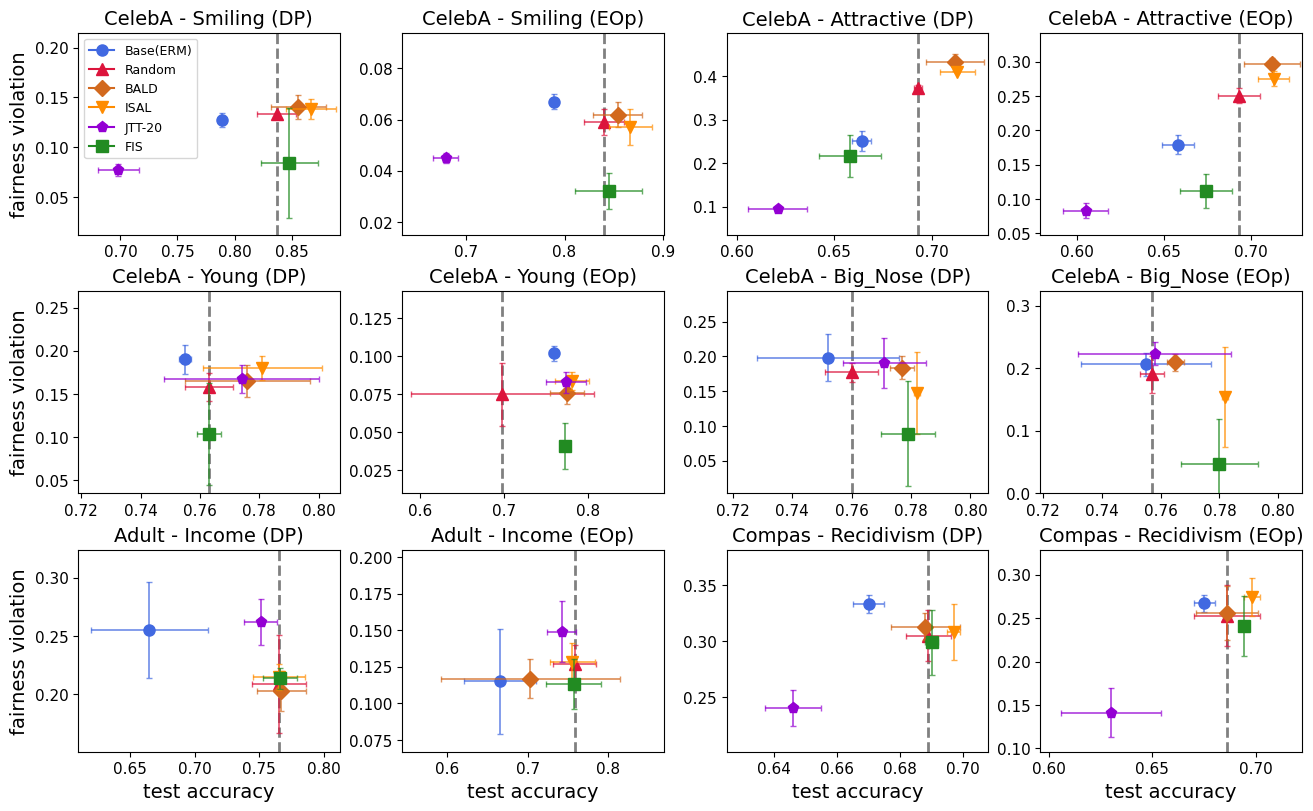

In [1]:

import matplotlib.pyplot as plt

data = {
    'CelebA - Smiling (DP)': {
        'Base(ERM)': ((0.789, 0.003), (0.127, 0.007)), 'Random': ((0.837, 0.017), (0.133, 0.001)), 
        'BALD': ((0.856, 0.024), (0.140, 0.012)), 'ISAL': ((0.867, 0.022), (0.138, 0.010)), 
        'JTT-20': ((0.698, 0.018), (0.077, 0.006)), 'FIS': ((0.848, 0.025), (0.084, 0.055))
    },
    'CelebA - Smiling (EOp)': {
        'Base(ERM)': ((0.789, 0.003), (0.067, 0.003)), 'Random': ((0.840, 0.020), (0.059, 0.005)), 
        'BALD': ((0.854, 0.025), (0.062, 0.005)), 'ISAL': ((0.867, 0.022), (0.057, 0.007)), 
        'JTT-20': ((0.679, 0.013), (0.045, 0.002)), 'FIS': ((0.845, 0.034), (0.032, 0.007))
    },
    'CelebA - Attractive (DP)': {
        'Base(ERM)': ((0.664, 0.005), (0.251, 0.022)), 'Random': ((0.693, 0.002), (0.372, 0.006)), 
        'BALD': ((0.712, 0.015), (0.431, 0.020)), 'ISAL': ((0.713, 0.009), (0.410, 0.003)), 
        'JTT-20': ((0.621, 0.015), (0.094, 0.004)), 'FIS': ((0.658, 0.016), (0.217, 0.048))
    },
    'CelebA - Attractive (EOp)': {
        'Base(ERM)': ((0.658, 0.009), (0.179, 0.014)), 'Random': ((0.693, 0.012), (0.250, 0.011)), 
        'BALD': ((0.712, 0.016), (0.297, 0.008)), 'ISAL': ((0.713, 0.009), (0.275, 0.011)), 
        'JTT-20': ((0.605, 0.013), (0.083, 0.011)), 'FIS': ((0.674, 0.015), (0.112, 0.025))
    },
    'CelebA - Young (DP)': {
        'Base(ERM)': ((0.755, 0.002), (0.190, 0.017)), 'Random': ((0.763, 0.008), (0.158, 0.016)), 
        'BALD': ((0.776, 0.021), (0.165, 0.019)), 'ISAL': ((0.781, 0.020), (0.180, 0.014)), 
        'JTT-20': ((0.774, 0.026), (0.167, 0.016)), 'FIS': ((0.763, 0.004), (0.104, 0.059))
    },
    'CelebA - Young (EOp)': {
        'Base(ERM)': ((0.759, 0.005), (0.102, 0.005)), 'Random': ((0.698, 0.109), (0.075, 0.021)), 
        'BALD': ((0.775, 0.020), (0.076, 0.007)), 'ISAL': ((0.781, 0.020), (0.084, 0.006)), 
        'JTT-20': ((0.774, 0.024), (0.083, 0.007)), 'FIS': ((0.773, 0.003), (0.041, 0.015))
    },
    'CelebA - Big_Nose (DP)': {
        'Base(ERM)': ((0.752, 0.024), (0.198, 0.034)), 'Random': ((0.760, 0.009), (0.177, 0.014)), 
        'BALD': ((0.777, 0.004), (0.184, 0.016)), 'ISAL': ((0.782, 0.001), (0.148, 0.059)), 
        'JTT-20': ((0.771, 0.014), (0.191, 0.036)), 'FIS': ((0.779, 0.009), (0.089, 0.076))
    },
    'CelebA - Big_Nose (EOp)': {
        'Base(ERM)': ((0.755, 0.022), (0.206, 0.018)), 'Random': ((0.757, 0.004), (0.190, 0.029)), 
        'BALD': ((0.765, 0.003), (0.209, 0.014)), 'ISAL': ((0.782, 0.001), (0.154, 0.080)), 
        'JTT-20': ((0.758, 0.026), (0.223, 0.018)), 'FIS': ((0.780, 0.013), (0.046, 0.072))
    },
    'Adult - Income (DP)': {
        'Base(ERM)': ((0.665, 0.045), (0.255, 0.041)), 'Random': ((0.765, 0.021), (0.209, 0.042)), 
        'BALD': ((0.767, 0.019), (0.203, 0.017)), 'ISAL': ((0.765, 0.020), (0.215, 0.011)), 
        'JTT-20': ((0.751, 0.013), (0.262, 0.020)), 'FIS': ((0.766, 0.013), (0.214, 0.009))
    },
    'Adult - Income (EOp)': {
        'Base(ERM)': ((0.665, 0.045), (0.115, 0.036)), 'Random': ((0.758, 0.027), (0.127, 0.013)), 
        'BALD': ((0.703, 0.111), (0.117, 0.013)), 'ISAL': ((0.755, 0.028), (0.128, 0.013)), 
        'JTT-20': ((0.742, 0.018), (0.149, 0.021)), 'FIS': ((0.757, 0.034), (0.113, 0.017))
    },
    'Compas - Recidivism (DP)': {
        'Base(ERM)': ((0.670, 0.005), (0.333, 0.008)), 'Random': ((0.689, 0.007), (0.305, 0.023)), 
        'BALD': ((0.688, 0.011), (0.313, 0.012)), 'ISAL': ((0.697, 0.002), (0.308, 0.025)), 
        'JTT-20': ((0.646, 0.009), (0.240, 0.016)), 'FIS': ((0.690, 0.002), (0.299, 0.029))
    },
    'Compas - Recidivism (EOp)': {
        'Base(ERM)': ((0.675, 0.005), (0.267, 0.010)), 'Random': ((0.686, 0.016), (0.253, 0.035)), 
        'BALD': ((0.686, 0.015), (0.256, 0.031)), 'ISAL': ((0.698, 0.004), (0.274, 0.022)), 
        'JTT-20': ((0.630, 0.024), (0.141, 0.028)), 'FIS': ((0.694, 0.002), (0.241, 0.035))
    }
}


fig, axes = plt.subplots(3, 4, figsize=(13, 8), constrained_layout=True)

plot_order = list(data.keys())
methods = ['Base(ERM)', 'Random', 'BALD', 'ISAL', 'JTT-20', 'FIS']
markers = ['o',  '^', 'D', 'v', 'p','s']
colors = ['royalblue', 'crimson', 'chocolate',  'darkorange', 'darkviolet', 'forestgreen']


for idx, (ax, title) in enumerate(zip(axes.flat, plot_order)):
    x = [data[title][method][0][0] for method in methods]
    y = [data[title][method][1][0] for method in methods]
    x_err = [data[title][method][0][1] for method in methods]
    y_err = [data[title][method][1][1] for method in methods]
    
    for i, method in enumerate(methods):
        zorder = 3 if method == 'FIS' else 2

        ax.errorbar(
            x[i], y[i], xerr=x_err[i], yerr=y_err[i], 
            fmt='none', color=colors[i], capsize=2, elinewidth=1.3, alpha=0.7, zorder=zorder
        )
        
        ax.plot(
            x[i], y[i], marker=markers[i], color=colors[i], label=method if idx == 0 else "", 
            markersize=8,  zorder=zorder,
        )
        
        
    random_test_acc = data[title]['Random'][0][0]
    ax.axvline(x=random_test_acc, color='gray', linestyle='--', linewidth=2, zorder=1)
    
    x_min = min(x) - max(x_err)
    x_max = max(x) + max(x_err)
    y_min = min(y) - max(y_err)
    y_max = max(y) + max(y_err)
    ax.set_xlim(x_min - 0.01, x_max)
    ax.set_ylim(max(0, y_min-0.01), y_max + 0.02)
    ax.tick_params(axis='y', labelsize=11)  
    ax.tick_params(axis='x', labelsize=11) 

    ax.set_title(title,fontsize=14)
    if idx // 8 == 1:
        ax.set_xlabel('test accuracy', fontsize=14)
    
    if idx%4 == 0:
        ax.set_ylabel('fairness violation', fontsize=14)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=9)

plt.show()


### Plot the impact of label budgets

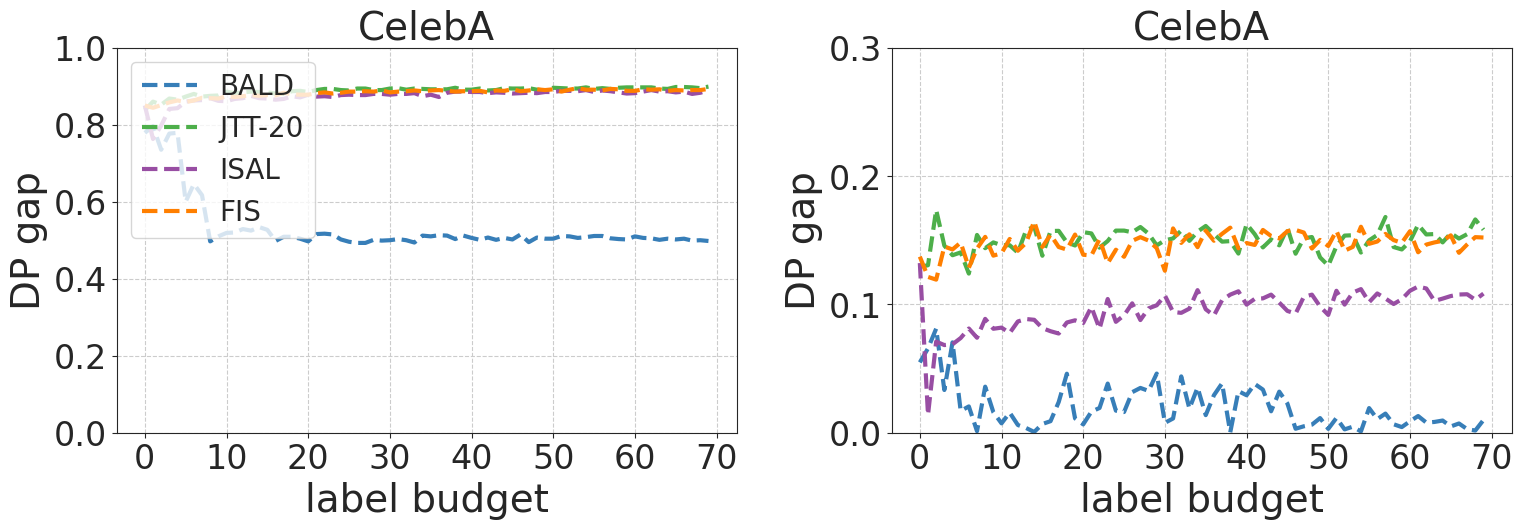

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_style('ticks')
palette = plt.get_cmap('Set1')

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

fig, axs = plt.subplots(1, 2, figsize=(18, 5))


#############################
dataset_type = 'celeba'
runs = 0 #default random seed
fair_metric = 'dp'
sel_layers = '4'

if dataset_type == 'adult':
    dataset_tag, tol, avg_cnt =  'Adult', 0.05, 3
    sensitive_attributes = 'sex' #age
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-{sensitive_attributes}-runs{runs}/', 'default' #file-suffix represents the label budget
    gap_bounds, acc_bounds = (0.15, 0.35), (0.5, 0.8)
    step_gap, window_size = 20, 30
elif dataset_type == 'compas':
    dataset_tag, tol, avg_cnt =  'Compas', 0.05, 3
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-runs2/', 'default'
    gap_bounds, acc_bounds = (0.25, 0.35), (0.65, 0.75)
    step_gap, window_size = 20, 15
elif dataset_type == 'jigsaw':
    dataset_tag, tol, avg_cnt =  'Jigsaw', 0.05, 5
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-runs{runs}/', 'default'
    gap_bounds, acc_bounds = (0, 0.1), (0.7, 0.8)
    step_gap, window_size = 10, 6
elif dataset_type == 'celeba':
    dataset_tag, tol, avg_cnt = 'CelebA', 0.05, 3
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-runs{runs}/', 'default'
    gap_bounds, acc_bounds = (0, 0.3), (0, 1)
    step_gap, window_size = 10, 1
    binary_target = 'Smiling' # Young, Big_Nose, Attractive
    
baseline_labels_pairs = {'ERM': 's0', 
                   'Random': 's1',
                   'BALD': 's6',
                   'ISAL': 's8',
                   'JTT-20':'s7',
                   'FIS': 's5',
}
baseline_labels = ['BALD', 'JTT-20', 'ISAL'] ## illustrated  baselines
proposed_method = 'FIS' #'FIS-pred'
baseline_labels.append(proposed_method)

baseline_tags = [baseline_labels_pairs[baseline] for baseline in baseline_labels] 

if dataset_type == 'celeba':
    files = [f'{binary_target}_{baseline_tag}_{fair_metric}_{sel_layers}_{file_suffix}.log' for baseline_tag in baseline_tags]
else:
    files = [f'label_{baseline_tag}_{fair_metric}_{sel_layers}_{file_suffix}.log' for baseline_tag in baseline_tags]


def extract_data(file_path):
    with open(file_path, 'r') as file:
        data = re.findall(r'test acc: ([0-9.]+) .+ test dp gap: ([0-9.]+)', file.read())
    return [float(x[0]) for x in data], [float(x[1]) for x in data]

acc_data, gap_data = zip(*(extract_data(root + f) for f in files))
smoothed_acc = [moving_average(acc, window_size) for acc in acc_data]
smoothed_gap = [moving_average(gap, window_size) for gap in gap_data]
rounds = list(range(len(smoothed_acc[0])))

for idx, (acc, label) in enumerate(zip(smoothed_acc[1:], baseline_labels)):
    axs[0].plot(rounds, acc, color=palette(idx+1), label=label, linewidth=3, linestyle='--')
axs[0].plot(rounds, smoothed_acc[0], color=palette(4), label=proposed_method, linewidth=3, linestyle='--')
axs[0].set(title=dataset_tag, xlabel='label budget', ylabel='test accuracy', ylim=acc_bounds, xticks=np.arange(0, len(smoothed_acc[0])+10, step_gap))
axs[0].legend(loc='upper left', frameon=True, fontsize=20)
axs[0].grid(True, linestyle='--')
axs[0].tick_params(axis='both', labelsize=24)
axs[0].set_title(dataset_tag, fontsize=28)
axs[0].set_xlabel('label budget', fontsize=28)
axs[0].set_ylabel('DP gap', fontsize=28)

for idx, (gap, label) in enumerate(zip(smoothed_gap[1:], baseline_labels)):
    axs[1].plot(rounds, gap, color=palette(idx+1), label=label, linewidth=3, linestyle='--')
axs[1].plot(rounds, smoothed_gap[0], color=palette(4), label=proposed_method, linewidth=3, linestyle='--')
axs[1].set(title=dataset_tag, xlabel='label budget', ylabel='DP gap', ylim=gap_bounds, xticks=np.arange(0, len(smoothed_gap[0])+10, step_gap))
axs[1].grid(True, linestyle='--')
axs[1].tick_params(axis='both', labelsize=24)

axs[1].set_title(dataset_tag, fontsize=28)
axs[1].set_xlabel('label budget', fontsize=28)
axs[1].set_ylabel('DP gap', fontsize=28)

plt.subplots_adjust(wspace=0.25)
plt.show()

fig_path = 'figures/'
fig.savefig(f'{fig_path}{dataset_type}_impact_label_budget-mini.pdf', dpi=300, bbox_inches='tight')
